<a href="https://colab.research.google.com/github/ShohamWeiss/Machine-Vision-Project/blob/master/Project%20Research/Image_Segmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following the tutorial on [here](https://www.tensorflow.org/tutorials/images/segmentation)

set up GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [3]:
import tensorflow as tf

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Grabbing the data from [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 225.0
  input_mask -= 1 # {1,2,3} -> {0,1,2}
  return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

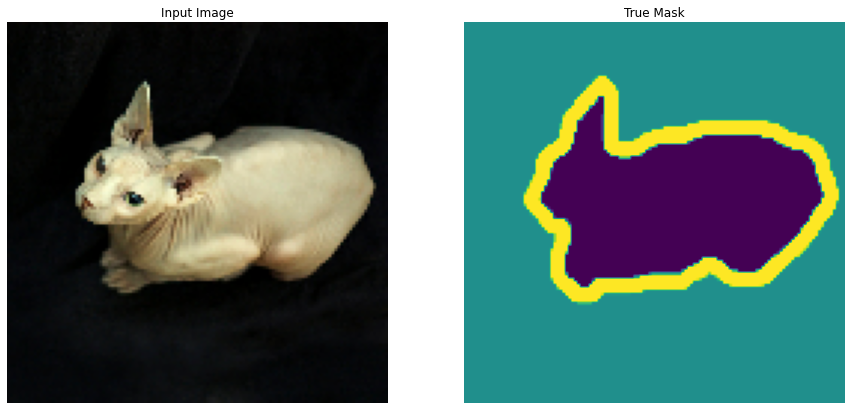

In [13]:
for image, mask in train.take(1):
  display([image, mask])

## Define the Model

In [14]:
OUTPUT_CHANNELS = 3

Using ModbileNet2 as encoder and Pix2Pix for decoder

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

# Use the activation of these layers
layer_names = [
      'block_1_expand_relu', # 64x64
      'block_3_expand_relu', # 32x32
      'block_6_expand_relu', # 16x16
      'block_13_expand_relu', # 8x8
      'block_16_expand_relu', # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

Adding the upsampling

In [16]:
up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3), # 32x32 -> 64x64
]

In [17]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  
  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same') #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

In [18]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

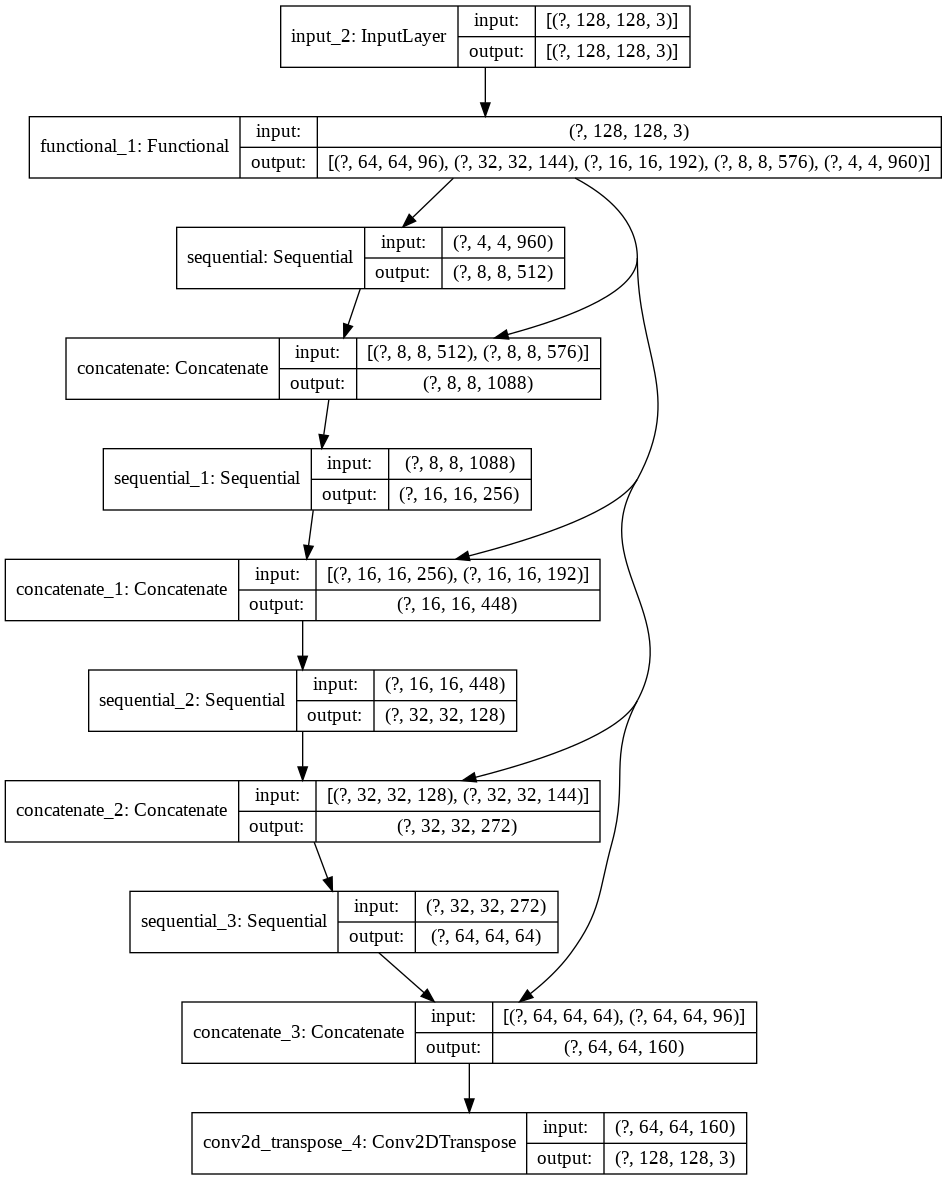

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

Trying out model before training

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

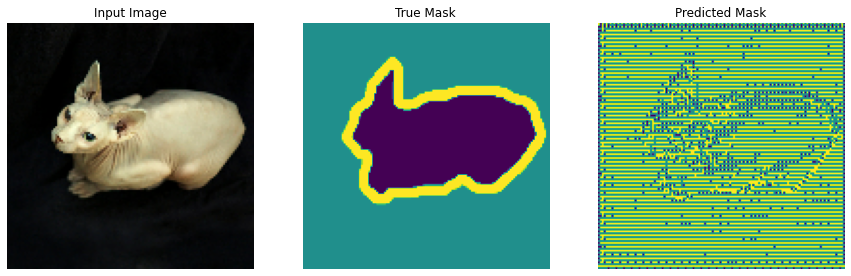

In [22]:
sample_mask = 1
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
show_predictions()

Callback function to observe the model improving

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}/n'.format(epoch+1))

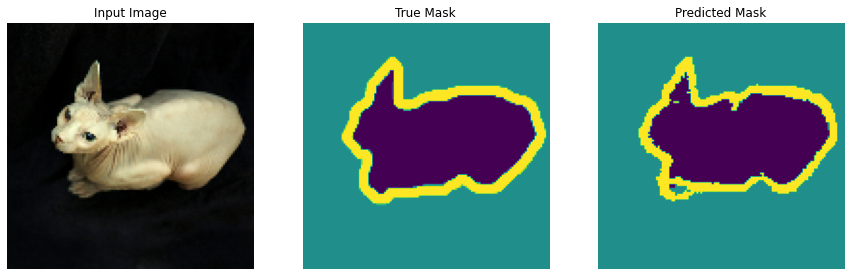


Sample Prediction after epoch 5/n
57/57 [==============================] - 9s 154ms/step - loss: 0.2319 - accuracy: 0.9012 - val_loss: 0.2948 - val_accuracy: 0.8811


In [24]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

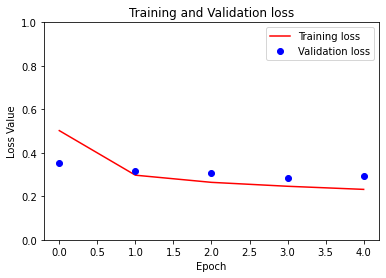

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

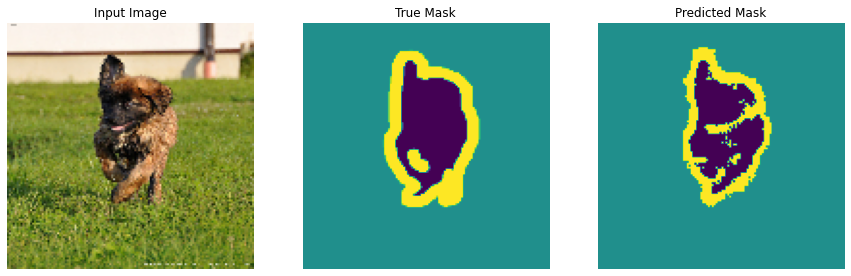

In [26]:
show_predictions(test_dataset, 1)

Adding Square around original image

In [53]:
import numpy as np
import matplotlib.patches as patches

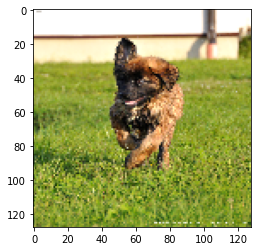

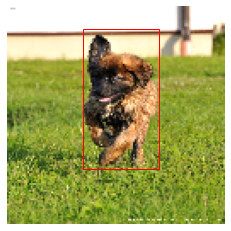

In [57]:
def findDog(image):
  plt.imshow(image)
  pred_mask = model.predict(image[tf.newaxis, ...])
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  pred_mask = pred_mask[0]
  minX = 128
  maxX = 0
  minY = 128
  maxY = 0
  for x in range(128):
    for y in range(128):
      # print(np.array(pred_mask[y,x])[0])
      if (np.array(pred_mask[y,x]) == np.array(2)):
        if (x < minX):
          minX = x
        if (x > maxX):
          maxX = x
        if (y < minY):
          minY = y
        if (y > maxY):
          maxY = y
  # pred_mask_img = tf.keras.preprocessing.image.array_to_img(pred_mask)
  rect = patches.Rectangle((minX,minY), maxX-minX, maxY-minY,linewidth=1,edgecolor='r',facecolor='none')
  fig,ax = plt.subplots(1)
  ax.add_patch(rect)
  ax.imshow(image)
  ax.axis('off')
for image, mask in test_dataset.take(1):
  findDog(image[0])

In [ ]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]